In [ ]:
#!pip install flashtorch torch==1.5.0 torchvision==0.6.0 -U
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html --user

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import utils
import matplotlib.pyplot as plt

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

import torchvision.models as models

#
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

C:\Users\rodam\anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


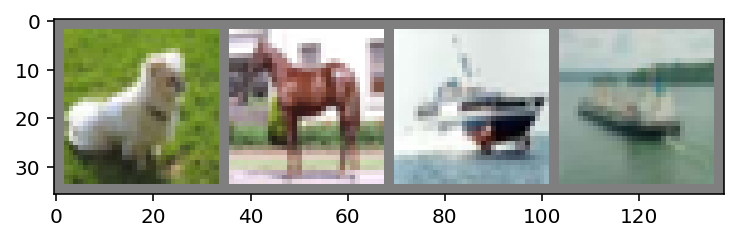

  dog horse  ship  ship


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.191
[1,  4000] loss: 1.810
[1,  6000] loss: 1.647
[1,  8000] loss: 1.593
[1, 10000] loss: 1.528
[1, 12000] loss: 1.492
[2,  2000] loss: 1.412
[2,  4000] loss: 1.376
[2,  6000] loss: 1.350
[2,  8000] loss: 1.328
[2, 10000] loss: 1.304
[2, 12000] loss: 1.280
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

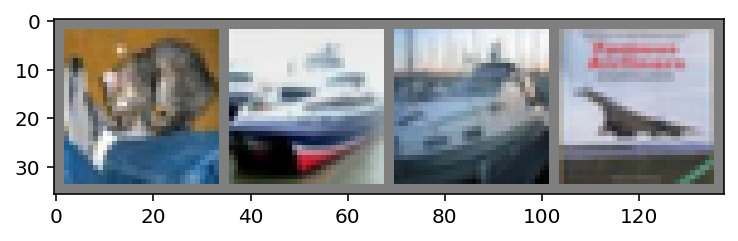

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [66]:
backprop = Backprop(net)

In [63]:
import cv2
from torchvision.utils import save_image

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 55.7 %
Accuracy for class car   is: 50.9 %
Accuracy for class bird  is: 39.5 %
Accuracy for class cat   is: 32.7 %
Accuracy for class deer  is: 49.0 %
Accuracy for class dog   is: 62.1 %
Accuracy for class frog  is: 60.1 %
Accuracy for class horse is: 58.9 %
Accuracy for class ship  is: 69.2 %
Accuracy for class truck is: 70.8 %


(-0.5, 680.5, 493.5, -0.5)

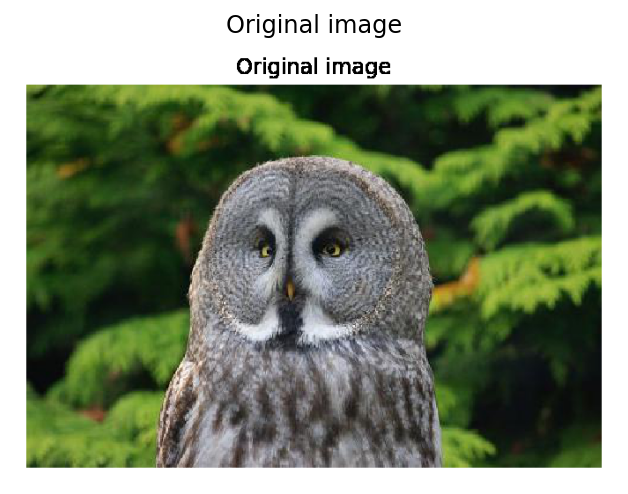

In [43]:
image = load_image('./images/owl.png')

plt.imshow(image)
plt.title('Original image')
plt.axis('off')

In [51]:
model = models.alexnet(pretrained=True)

In [68]:
backprop = Backprop(model)

<class 'torch.Tensor'>
1


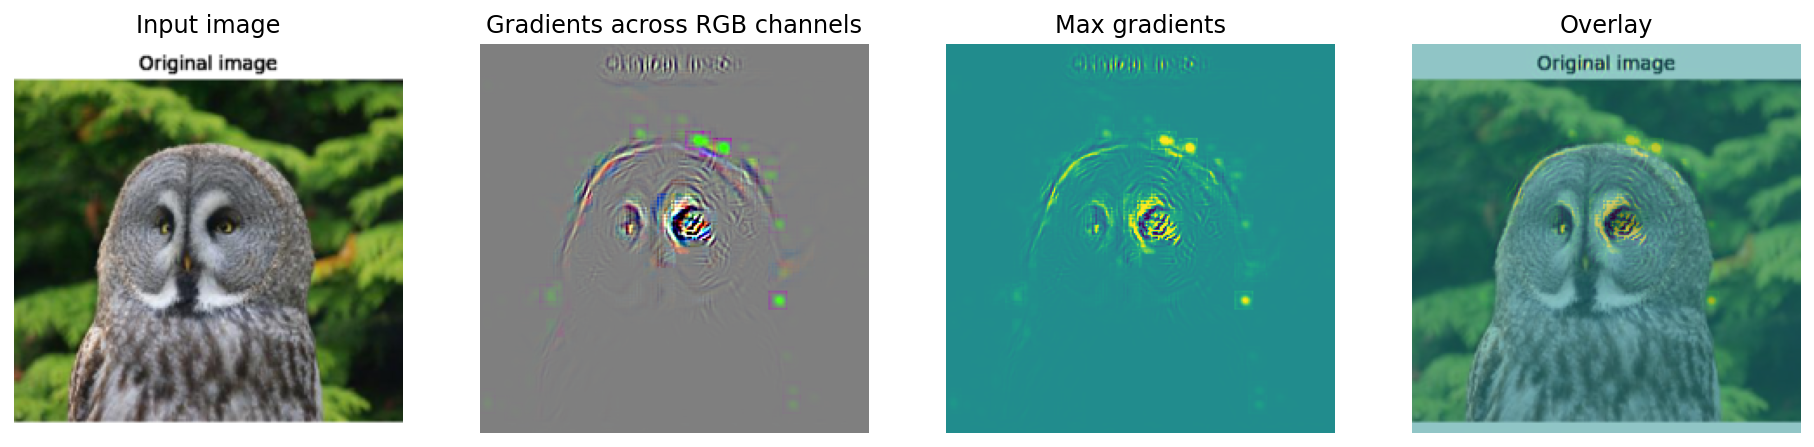

In [46]:
# Transform the input image to a tensor

owl = apply_transforms(image)
print(type(owl))
print(len(owl))

# Set a target class from ImageNet task: 24 in case of great gray owl

target_class = 24

# Ready to roll!

backprop.visualize(owl, target_class, guided=True)

In [61]:
imgs = []
target_classes = []
for data in testloader:
    images, labels = data
    for i in range(4):
        imgs.append(apply_transforms(images[i]))
        target_classes.append(labels[i].item())
print("done adding")

done adding


cat
ship
ship
plane
frog


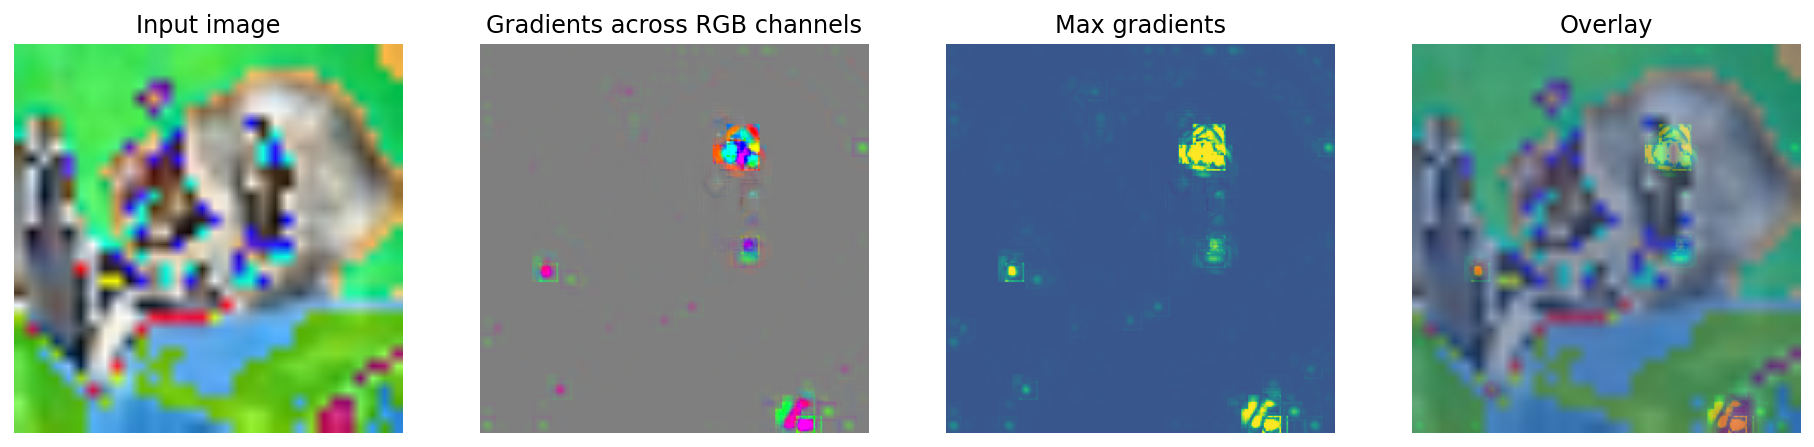

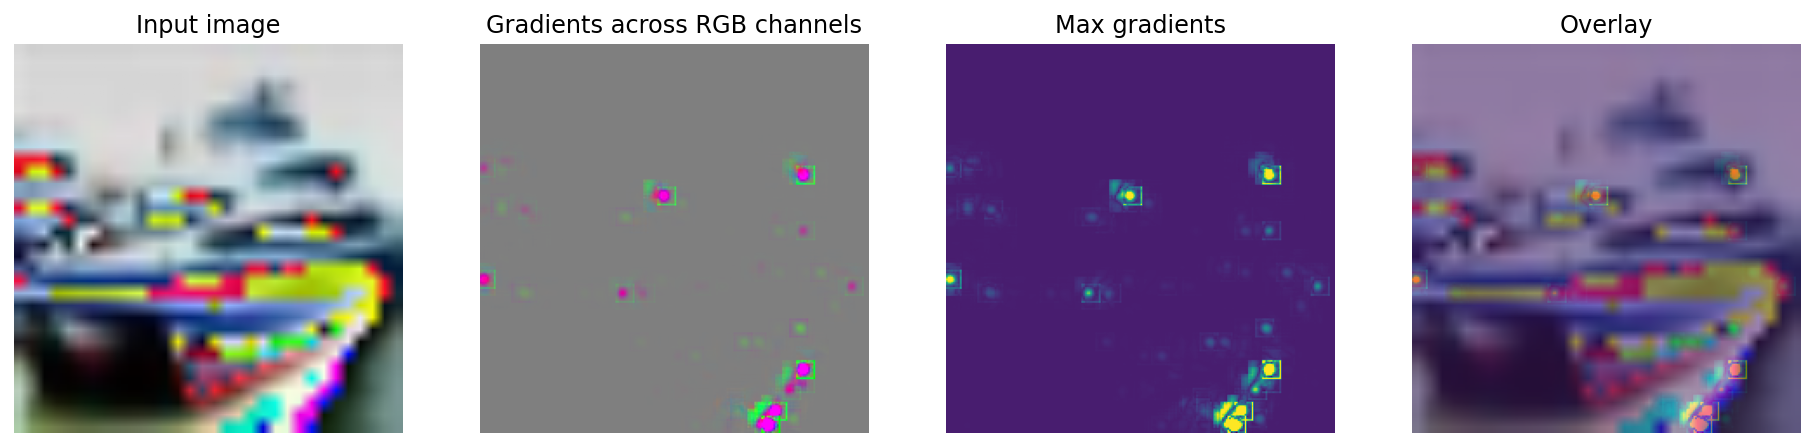

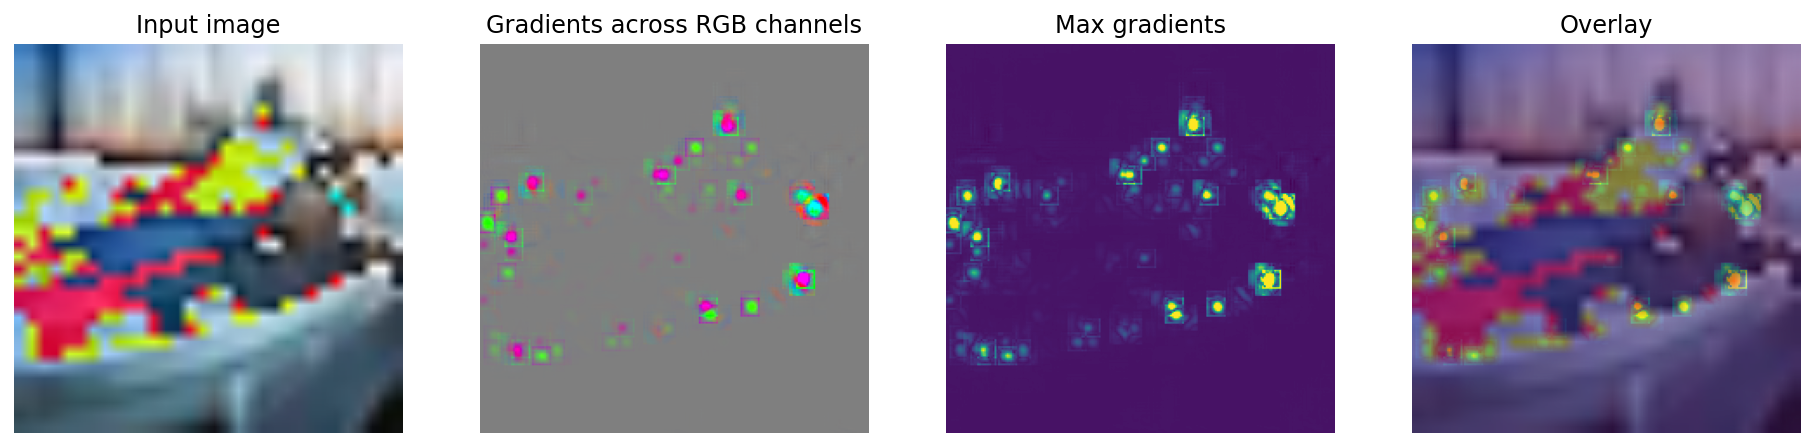

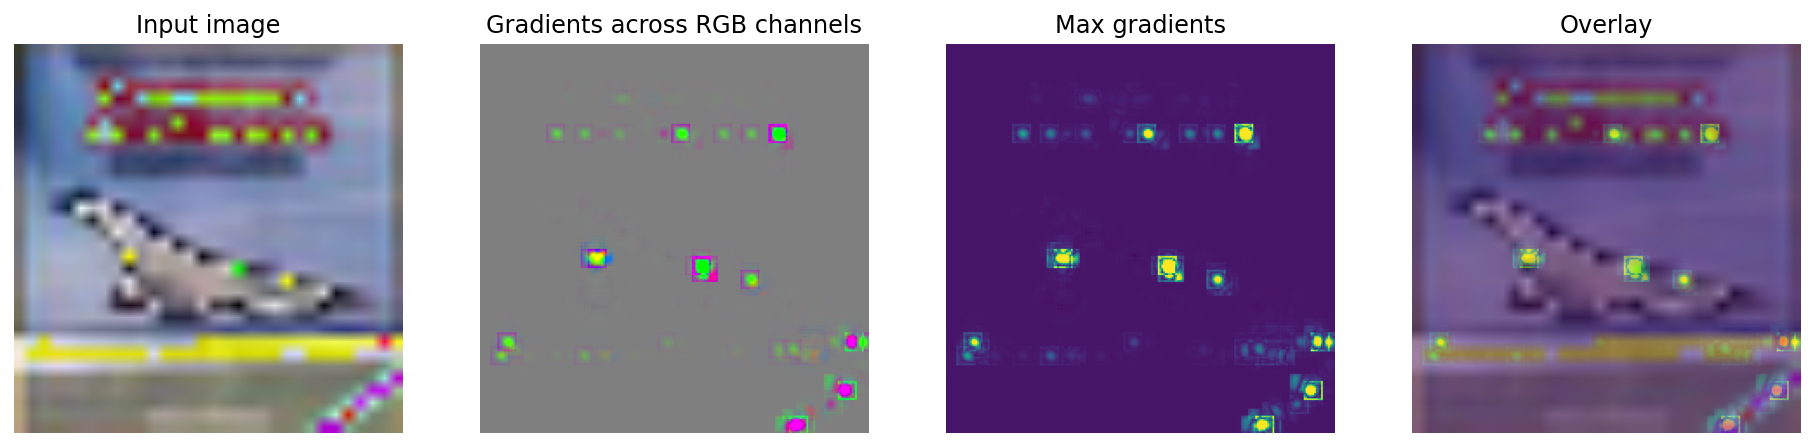

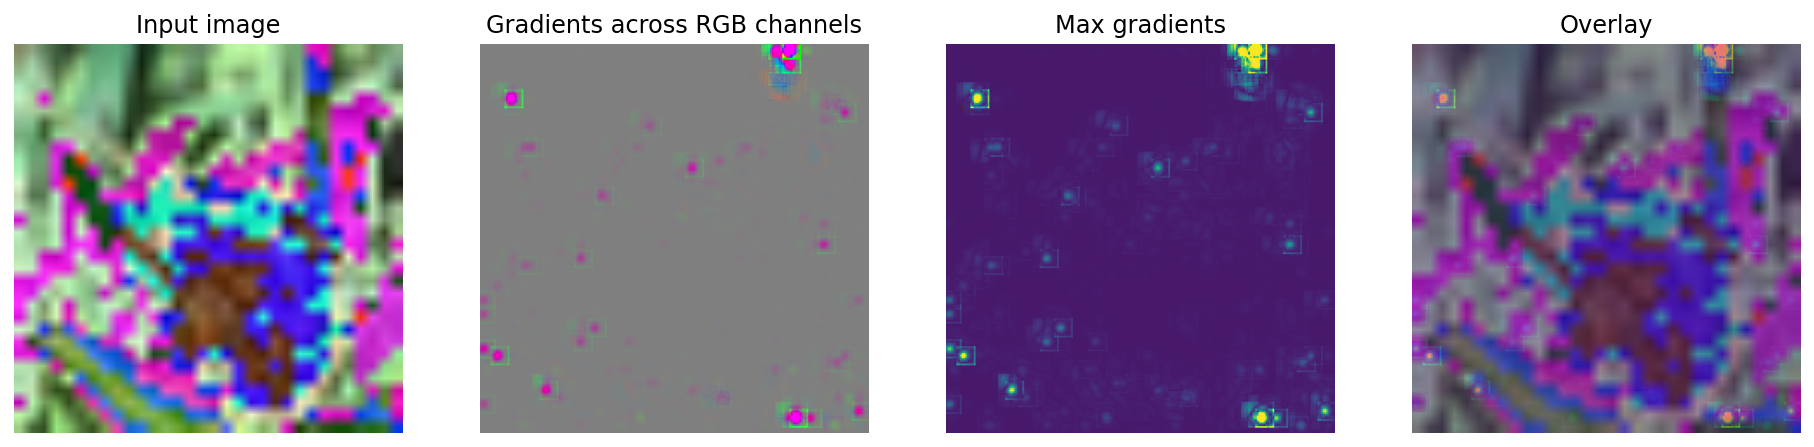

In [69]:
num_visualizations = 5 #anywhere from 1 - 10,000

for i in range(num_visualizations):
    backprop.visualize(imgs[i], target_classes[i], guided=True)
    print(classes[target_classes[i]])